# Analysis of disagreements

In this series of experiments, we use ablation studies to investigate the role of components highlighted by either Integrated Gradients or activation patching, but not both.

In [1]:
# Set up

%load_ext autoreload
%autoreload 2

import torch
import random
from transformer_lens import HookedTransformer
from transformer_lens.utils import get_device, get_act_name
import numpy as np
import matplotlib.pyplot as plt

from attribution_methods import integrated_gradients, activation_patching, highlight_components
from testing import Task, TaskDataset, logit_diff_metric, identify_outliers, average_correlation, measure_overlap, test_single_ablated_performance, test_multi_ablated_performance
from plotting import plot_attn, plot_attn_comparison, plot_correlation, plot_correlation_comparison, plot_bar_chart

/vol/bitbucket/mwl21/fypvenv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
torch.set_grad_enabled(False)
torch.cuda.empty_cache()

device = get_device()
model = HookedTransformer.from_pretrained("gpt2-small", device=device)

# Explicitly calculate and expose the result for each attention head
model.set_use_attn_result(True)
model.set_use_hook_mlp_in(True)

Loaded pretrained model gpt2-small into HookedTransformer


In [3]:
# Measure baseline performance

test_dataset = TaskDataset(Task.IOI)
test_dataloader = test_dataset.to_dataloader(batch_size=10)

baseline_scores = []

for i, (clean_input, _, labels) in enumerate(test_dataloader):
    if i >= 100:  # Limit to first 100 batches for performance
        break
    clean_tokens = model.to_tokens(clean_input)
    logits = model(clean_tokens)
    baseline_scores += [x.item() for x in logit_diff_metric(logits, labels)]

baseline_performance = np.mean(baseline_scores)
baseline_performance_std = np.std(baseline_scores)

print(f"Baseline performance: {baseline_performance:.3f} (Std {baseline_performance_std:.3f})")

Baseline performance: 0.661 (Std 2.164)


In [4]:
ig_mlp = torch.load("results/aligned/ioi/ig_mlp.pt")
ig_attn = torch.load("results/aligned/ioi/ig_attn.pt")

ap_mlp = torch.load("results/aligned/ioi/ap_mlp.pt")
ap_attn = torch.load("results/aligned/ioi/ap_attn.pt")

## Identify disagreements

In [5]:
# Identify statistically significant outlier components

scaled_ig_attn = ig_attn * 1e5
attn_outliers = identify_outliers(scaled_ig_attn, ap_attn)
mlp_outliers = identify_outliers(ig_mlp, ap_mlp, percentile=0.99)

In [6]:
batch_size = 10
num_samples = 100
num_batches = num_samples // batch_size

attn_outlier_hooks = [get_act_name("result", layer_idx) for layer_idx in range(model.cfg.n_layers)]
mlp_outlier_hooks = [get_act_name("post", layer_idx) for layer_idx in range(model.cfg.n_layers)]
hooks_filter = lambda x: (x in attn_outlier_hooks or x in mlp_outlier_hooks)

random_dataloader = test_dataset.to_dataloader(batch_size=batch_size, shuffle=True)

# Initialize dictionary to accumulate activations
activation_sums = {}
sample_count = 0

for batch_idx, (clean_prompts, corrupt_prompts, _) in enumerate(random_dataloader):
    if sample_count >= num_samples:
        break

    # Combine prompts and tokenize
    prompts_tokens = model.to_tokens(clean_prompts + corrupt_prompts)

    # Run model and collect cache
    _, prompt_cache = model.run_with_cache(prompts_tokens, names_filter=hooks_filter)

    for key, value in prompt_cache.items():
        if key not in activation_sums:
            activation_sums[key] = value.sum(dim=(0,1), keepdim=True)
        else:
            activation_sums[key] += value.sum(dim=(0,1), keepdim=True)

    sample_count += value.shape[0]  # Number of prompts processed so far

# Average activations over the collected samples
mean_corrupt_activations = {
    key: activation_sums[key] / sample_count for key in activation_sums
}


## Performance under isolated ablation

- Hypothesis: components which have high attribution scores in only one of the two methods are still important.
- Method: we measure the performance of a GPT2-small model when the components which are exclusive to only one method are ablated (with mean corrupt activations), one at a time.

### Attention heads

In [21]:
attn_outlier_isolated_ablation_scores = [{} for _ in range(100)]

for sample, layer, idx in attn_outliers:
    score = test_single_ablated_performance(model, layer, idx, mean_corrupt_activations, Task.IOI, is_attn=True)
    attn_outlier_isolated_ablation_scores[sample][(layer.item(), idx.item())] = score.item()

torch.save(attn_outlier_isolated_ablation_scores, "results/disagreements/attn_outlier_isolated_ablation_scores.pt")

Test IOI performance with ablated (tensor(3), tensor(4))
Mean performance: 0.6457406878471375
Test IOI performance with ablated (tensor(4), tensor(10))
Mean performance: 0.6554269790649414
Test IOI performance with ablated (tensor(5), tensor(11))
Mean performance: 0.6216720342636108
Test IOI performance with ablated (tensor(10), tensor(2))
Mean performance: 0.6477562785148621
Test IOI performance with ablated (tensor(10), tensor(10))
Mean performance: 0.6284366250038147
Test IOI performance with ablated (tensor(11), tensor(2))
Mean performance: 0.743817925453186
Test IOI performance with ablated (tensor(3), tensor(0))
Mean performance: 0.562957227230072
Test IOI performance with ablated (tensor(5), tensor(11))
Mean performance: 0.6216720342636108
Test IOI performance with ablated (tensor(7), tensor(3))
Mean performance: 0.5269188284873962
Test IOI performance with ablated (tensor(7), tensor(9))
Mean performance: 0.48060038685798645
Test IOI performance with ablated (tensor(8), tensor(6

In [ ]:
# Average model performance over all outlier components
attn_outlier_isolated_ablation_scores = torch.load("results/disagreements/attn_outlier_isolated_ablation_scores.pt")

per_sample_attn_outlier_isolated_ablated_scores = [
    np.mean(list(scores.values())) if len(scores) > 0 else 0.0 for scores in attn_outlier_isolated_ablation_scores
]
attn_outlier_isolated_ablated_performance = np.mean(per_sample_attn_outlier_isolated_ablated_scores)
print(f"Attn outlier isolated ablation performance: {attn_outlier_isolated_ablated_performance:.4f} (baseline: {baseline_performance:.4f})")

# Standard deviation of the performance over all outlier components
attn_outlier_isolated_ablated_performance_std = np.std(per_sample_attn_outlier_isolated_ablated_scores)
print(f"Attn outlier isolated ablation performance std: {attn_outlier_isolated_ablated_performance_std:.4f}")

Attn outlier isolated ablation performance: 0.1422 (baseline: 0.6608)
Attn outlier isolated ablation performance std: 0.1383


: 

In [10]:
# Control: ablate IG highlighted attention head
ig_attn_highlighted = highlight_components(ig_attn[:3])[1]
ig_highlighted_attn_ablation_scores = []

print(ig_attn_highlighted.shape)

for sample, layer, idx in ig_attn_highlighted:
    print(f"Evaluating sample {sample}")
    score = test_single_ablated_performance(model, layer, idx, mean_corrupt_activations, Task.IOI, is_attn=True)
    ig_highlighted_attn_ablation_scores.append(score.item())

average_ig_highlighted_attn_ablation_score = np.mean(ig_highlighted_attn_ablation_scores)
print(f"IG highlighted attention ablation performance: {average_ig_highlighted_attn_ablation_score:.4f} (baseline: {baseline_performance:.4f})")
# Standard deviation of the performance over all highlighted components
ig_highlighted_attn_ablation_scores_std = np.std(ig_highlighted_attn_ablation_scores)
print(f"IG highlighted attention ablation performance std: {ig_highlighted_attn_ablation_scores_std:.4f}")

torch.Size([44, 3])
Evaluating sample 0
Test IOI performance with ablated (tensor(3), tensor(4))
Mean performance: -0.610636293888092
Evaluating sample 0
Test IOI performance with ablated (tensor(4), tensor(10))
Mean performance: 0.5979264974594116
Evaluating sample 0
Test IOI performance with ablated (tensor(5), tensor(11))
Mean performance: -0.024455854669213295
Evaluating sample 0
Test IOI performance with ablated (tensor(10), tensor(2))
Mean performance: 0.7719446420669556
Evaluating sample 0
Test IOI performance with ablated (tensor(11), tensor(2))
Mean performance: 0.6148817539215088
Evaluating sample 1
Test IOI performance with ablated (tensor(0), tensor(6))
Mean performance: 0.015024978667497635
Evaluating sample 1
Test IOI performance with ablated (tensor(3), tensor(0))
Mean performance: -0.2405657172203064
Evaluating sample 1
Test IOI performance with ablated (tensor(3), tensor(4))
Mean performance: -0.610636293888092
Evaluating sample 1
Test IOI performance with ablated (ten

In [14]:
# Control: ablate AP highlighted attention head = attribution scores from activation patching
ap_highlighted_attn = highlight_components(ap_attn)[0]
ap_highlighted_attn_scores = ap_highlighted_attn * ap_attn

average_ap_highlighted_attn_ablation_score = ap_highlighted_attn_scores.mean()  # Average over all samples
ap_highlighted_attn_ablation_scores_std = ap_highlighted_attn_scores.std()  # Standard deviation over all samples

print(f"AP highlighted attention ablation performance: {average_ap_highlighted_attn_ablation_score:.4f}")
print(f"AP highlighted attention ablation performance std: {ap_highlighted_attn_ablation_scores_std:.4f}")

AP highlighted attention ablation performance: -0.0150
AP highlighted attention ablation performance std: 0.4020


In [17]:
# Control: random ablations for attention heads
all_attn_indices = [(layer, idx) for layer in range(model.cfg.n_layers) for idx in range(model.cfg.n_heads)]
random_attn_targets = random.sample(all_attn_indices, 100)

average_random_attn_ablation_scores = []
for layer, idx in random_attn_targets:
    score = test_single_ablated_performance(model, layer, idx, mean_corrupt_activations, Task.IOI, is_attn=True)
    average_random_attn_ablation_scores.append(score.item())

average_random_attn_ablation_performance = np.mean(average_random_attn_ablation_scores)
average_random_attn_ablation_performance_std = np.std(average_random_attn_ablation_scores)
print(f"Average random attention ablation performance: {average_random_attn_ablation_performance:.3f} (std {average_random_attn_ablation_performance_std:.3f})")


Test IOI performance with ablated (4, 9)
Mean performance: 0.6681474447250366
Test IOI performance with ablated (11, 3)
Mean performance: 0.6665108799934387
Test IOI performance with ablated (3, 8)
Mean performance: 0.6423958539962769
Test IOI performance with ablated (10, 1)
Mean performance: 0.6501345038414001
Test IOI performance with ablated (8, 5)
Mean performance: 0.6620019674301147
Test IOI performance with ablated (0, 7)
Mean performance: 0.6941593885421753
Test IOI performance with ablated (11, 9)
Mean performance: 0.6637417078018188
Test IOI performance with ablated (4, 4)
Mean performance: 0.6239476799964905
Test IOI performance with ablated (1, 0)
Mean performance: 0.662947952747345
Test IOI performance with ablated (0, 4)
Mean performance: 0.6742363572120667
Test IOI performance with ablated (8, 3)
Mean performance: 0.6586090326309204
Test IOI performance with ablated (9, 6)
Mean performance: 0.7769006490707397
Test IOI performance with ablated (6, 6)
Mean performance: 0.6

In [ ]:
# Control: ablate IG and AP highlighted attention heads
ig_ap_attn_highlighted = highlight_components(ig_attn[:3])[0] ^ highlight_components(ap_attn[:3])[0]
ig_ap_attn_highlighted = ig_ap_attn_highlighted.nonzero()
ig_ap_highlighted_attn_ablation_scores = []

print(ig_ap_attn_highlighted.shape)

for sample, layer, idx in ig_ap_attn_highlighted:
    print(f"Evaluating sample {sample}")
    score = test_single_ablated_performance(model, layer, idx, mean_corrupt_activations, Task.IOI, is_attn=True)
    ig_ap_highlighted_attn_ablation_scores.append(score.item())

average_ig_ap_highlighted_attn_ablation_score = np.mean(ig_ap_highlighted_attn_ablation_scores)
print(f"IG AP highlighted attention ablation performance: {average_ig_ap_highlighted_attn_ablation_score:.4f}")
# Standard deviation of the performance over all highlighted components
ig_ap_highlighted_attn_ablation_scores_std = np.std(ig_ap_highlighted_attn_ablation_scores)
print(f"IG AP highlighted attention ablation performance std: {ig_ap_highlighted_attn_ablation_scores_std:.4f}")

torch.Size([14, 3])
Evaluating sample 0
Test IOI performance with ablated (tensor(0), tensor(6))
Mean performance: 0.015024978667497635
Evaluating sample 0
Test IOI performance with ablated (tensor(8), tensor(6))
Mean performance: 0.2971397638320923
Evaluating sample 0
Test IOI performance with ablated (tensor(8), tensor(10))
Mean performance: 0.12308072298765182
Evaluating sample 0
Test IOI performance with ablated (tensor(9), tensor(9))
Mean performance: 0.45044177770614624
Evaluating sample 0
Test IOI performance with ablated (tensor(10), tensor(10))
Mean performance: 0.6504391431808472
Evaluating sample 0
Test IOI performance with ablated (tensor(11), tensor(3))
Mean performance: 0.5666539072990417
Evaluating sample 0
Test IOI performance with ablated (tensor(11), tensor(8))
Mean performance: 0.1611528992652893
Evaluating sample 1
Test IOI performance with ablated (tensor(0), tensor(6))
Mean performance: 0.015024978667497635
Evaluating sample 1
Test IOI performance with ablated (te

In [15]:
average_ig_attn_ablation_performance = 0.3245
average_ig_attn_ablation_performance_std = 0.3730

average_ap_attn_ablation_performance = -0.0150
average_ap_attn_ablation_performance_std = 0.402

average_random_attn_ablation_performance = 0.651
average_random_attn_ablation_performance_std = 0.041

average_ig_ap_highlighted_attn_ablation_score = 0.3044
average_ig_ap_highlighted_attn_ablation_scores_std = 0.2332

average_outlier_attn_ablation_performance = 0.1422
average_outlier_attn_ablation_performance_std = 0.1383

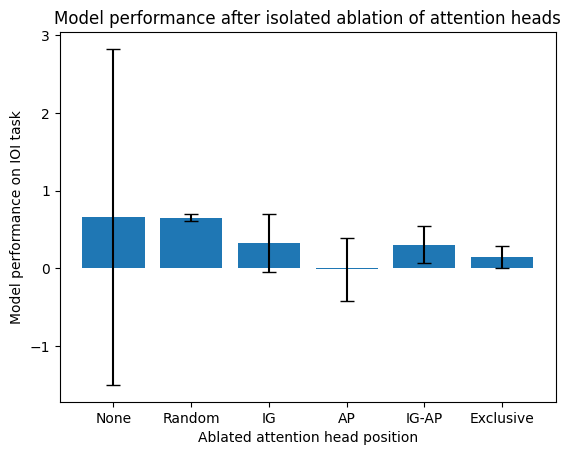

In [16]:
# Plot impact of isolated ablation of attention heads
plt.title("Model performance after isolated ablation of attention heads")
plt.xlabel("Ablated attention head position")
plt.ylabel("Model performance on IOI task")

xs = ["None", "Random", "IG", "AP", "IG-AP", "Exclusive"]
ys = [
    baseline_performance,
    average_random_attn_ablation_performance,
    average_ig_attn_ablation_performance,
    average_ap_attn_ablation_performance,
    average_ig_ap_highlighted_attn_ablation_score,
    average_outlier_attn_ablation_performance
]
yerr = [
    baseline_performance_std,
    average_random_attn_ablation_performance_std,
    average_ig_attn_ablation_performance_std,
    average_ap_attn_ablation_performance_std,
    average_ig_ap_highlighted_attn_ablation_scores_std,
    average_outlier_attn_ablation_performance_std
]

plt.bar(xs, ys, yerr=yerr, capsize=5)
plt.show()


# # Plot an example

# plt.title("Model performance after isolated ablation of exclusive attention heads")
# plt.xlabel("Ablated attention head position")
# plt.ylabel("Model performance on IOI task")

# xs = ["None"] + [str(k) for k in attn_outlier_isolated_ablation_scores[0].keys()]
# ys = [baseline_performance] + [v for v in attn_outlier_isolated_ablation_scores[0].values()]

# plt.bar(xs, ys)
# plt.show()

### Neurons

In [26]:
mlp_outlier_isolated_ablation_scores = [{} for _ in range(3)]

for sample, layer, idx in mlp_outliers:
    if sample > 3:
        break
    score = test_single_ablated_performance(model, layer, idx, mean_corrupt_activations, Task.IOI, is_attn=False)
    mlp_outlier_isolated_ablation_scores[sample][(layer.item(), idx.item())] = score.item()

torch.save(mlp_outlier_isolated_ablation_scores, "results/disagreements/mlp_outlier_isolated_ablation_scores.pt")

Test IOI performance with ablated (tensor(0), tensor(327))
Mean performance: 0.6649355888366699
Test IOI performance with ablated (tensor(0), tensor(333))
Mean performance: 0.6618719696998596
Test IOI performance with ablated (tensor(0), tensor(499))
Mean performance: 0.650482714176178
Test IOI performance with ablated (tensor(0), tensor(821))
Mean performance: 0.6576307415962219
Test IOI performance with ablated (tensor(0), tensor(1046))
Mean performance: 0.653980016708374
Test IOI performance with ablated (tensor(0), tensor(1100))
Mean performance: 0.6667650938034058
Test IOI performance with ablated (tensor(0), tensor(1115))
Mean performance: -0.23438966274261475
Test IOI performance with ablated (tensor(0), tensor(1346))
Mean performance: 0.6529499888420105
Test IOI performance with ablated (tensor(0), tensor(1937))
Mean performance: 0.6716105937957764
Test IOI performance with ablated (tensor(0), tensor(2077))
Mean performance: 0.6601004600524902
Test IOI performance with ablated 

IndexError: list index out of range

In [32]:
# Average model performance over all outlier components
mlp_outlier_isolated_ablation_scores = torch.load("results/disagreements/mlp_outlier_isolated_ablation_scores.pt")

per_sample_mlp_outlier_isolated_ablated_scores = [
    np.mean(list(scores.values())) if len(scores) > 0 else 0.0 for scores in mlp_outlier_isolated_ablation_scores
]
mlp_outlier_isolated_ablated_performance = sum(per_sample_mlp_outlier_isolated_ablated_scores) / len(per_sample_mlp_outlier_isolated_ablated_scores)
print(f"MLP outlier isolated ablation performance: {mlp_outlier_isolated_ablated_performance:.4f} (baseline: {baseline_performance:.4f})")

# Standard deviation of the performance over all outlier components
mlp_outlier_isolated_ablated_performance_std = np.std(per_sample_mlp_outlier_isolated_ablated_scores)
print(f"MLP outlier isolated ablation performance std: {mlp_outlier_isolated_ablated_performance_std:.4f}")

MLP outlier isolated ablation performance: 0.6067 (baseline: 0.6608)
MLP outlier isolated ablation performance std: 0.0146


In [7]:
# Control: random ablations for neurons
all_mlp_indices = [(layer, idx) for layer in range(model.cfg.n_layers) for idx in range(model.cfg.d_mlp)]
random_mlp_targets = random.sample(all_mlp_indices, int(0.01 * model.cfg.n_layers * model.cfg.d_mlp))
average_random_mlp_ablation_performance = 0.0
for layer, idx in random_mlp_targets:
    score = test_single_ablated_performance(model, layer, idx, mean_corrupt_activations, Task.IOI, is_attn=False)
    average_random_mlp_ablation_performance += score.item()
average_random_mlp_ablation_performance /= len(random_mlp_targets)
print(f"Average random MLP ablation performance: {average_random_mlp_ablation_performance:.4f} (baseline: {baseline_performance:.4f})")


Test IOI performance with ablated (5, 1042)
Mean performance: 0.649203896522522
Test IOI performance with ablated (2, 526)
Mean performance: 0.6573345065116882
Test IOI performance with ablated (7, 1119)
Mean performance: 0.6471354961395264
Test IOI performance with ablated (9, 2986)
Mean performance: 0.6606302857398987
Test IOI performance with ablated (5, 1438)
Mean performance: 0.6774914264678955
Test IOI performance with ablated (6, 1725)
Mean performance: 0.6790635585784912
Test IOI performance with ablated (11, 203)
Mean performance: 0.6636508107185364
Test IOI performance with ablated (8, 1164)
Mean performance: 0.656380295753479
Test IOI performance with ablated (3, 119)
Mean performance: 0.6781501173973083
Test IOI performance with ablated (3, 1615)
Mean performance: 0.6499609351158142
Test IOI performance with ablated (4, 2112)
Mean performance: 0.6275692582130432
Test IOI performance with ablated (5, 1415)
Mean performance: 0.6359657049179077
Test IOI performance with ablate

In [8]:
# Control: ablate IG highlighted attention head
ig_mlp_highlighted = highlight_components(ig_mlp[:3])[1]
ig_highlighted_mlp_ablation_scores = []
print(ig_mlp_highlighted.shape)

for sample, layer, idx in ig_mlp_highlighted:
    print(f"Evaluating sample {sample}")
    score = test_single_ablated_performance(model, layer, idx, mean_corrupt_activations, Task.IOI, is_attn=False)
    ig_highlighted_mlp_ablation_scores.append(score.item())

average_ig_highlighted_mlp_ablation_score = np.mean(ig_highlighted_mlp_ablation_scores)
print(f"IG highlighted MLP ablation performance: {average_ig_highlighted_mlp_ablation_score:.4f}")
# Standard deviation of the performance over all highlighted components
ig_highlighted_mlp_ablation_scores_std = np.std(ig_highlighted_mlp_ablation_scores)
print(f"IG highlighted MLP ablation performance std: {ig_highlighted_mlp_ablation_scores_std:.4f}")

torch.Size([11060, 3])
Evaluating sample 0
Test IOI performance with ablated (tensor(0), tensor(3))
Mean performance: 0.6602006554603577
Evaluating sample 0
Test IOI performance with ablated (tensor(0), tensor(5))
Mean performance: 0.6531661152839661
Evaluating sample 0
Test IOI performance with ablated (tensor(0), tensor(30))
Mean performance: 0.644450306892395
Evaluating sample 0
Test IOI performance with ablated (tensor(0), tensor(36))
Mean performance: 0.6811485886573792
Evaluating sample 0
Test IOI performance with ablated (tensor(0), tensor(44))
Mean performance: 0.7085971832275391
Evaluating sample 0
Test IOI performance with ablated (tensor(0), tensor(64))
Mean performance: 0.6707140207290649
Evaluating sample 0
Test IOI performance with ablated (tensor(0), tensor(115))
Mean performance: 0.6581515669822693
Evaluating sample 0
Test IOI performance with ablated (tensor(0), tensor(117))
Mean performance: 0.6710246205329895
Evaluating sample 0
Test IOI performance with ablated (ten

KeyboardInterrupt: 

In [9]:
average_ig_highlighted_mlp_ablation_score = np.mean(ig_highlighted_mlp_ablation_scores)
print(f"IG highlighted MLP ablation performance: {average_ig_highlighted_mlp_ablation_score:.4f}")
# Standard deviation of the performance over all highlighted components
ig_highlighted_mlp_ablation_scores_std = np.std(ig_highlighted_mlp_ablation_scores)
print(f"IG highlighted MLP ablation performance std: {ig_highlighted_mlp_ablation_scores_std:.4f}")

IG highlighted MLP ablation performance: 0.6423
IG highlighted MLP ablation performance std: 0.1094


In [17]:
# Control: ablate AP highlighted MLP neurons = attribution scores from activation patching
ap_highlighted_mlp = highlight_components(ap_mlp)[0]
ap_highlighted_mlp_scores = ap_highlighted_mlp * ap_mlp
average_ap_highlighted_mlp_ablation_score = ap_highlighted_mlp_scores.mean()  # Average over all samples
ap_highlighted_mlp_ablation_scores_std = ap_highlighted_mlp_scores.std()  # Standard deviation over all samples
print(f"AP highlighted MLP ablation performance: {average_ap_highlighted_mlp_ablation_score:.4f}")
print(f"AP highlighted MLP ablation performance std: {ap_highlighted_mlp_ablation_scores_std:.4f}")

AP highlighted MLP ablation performance: 0.0000
AP highlighted MLP ablation performance std: 0.0161


In [ ]:
# Control: ablate IG and AP highlighted MLP neurons
ig_ap_mlp_highlighted = highlight_components(ig_mlp[:2])[0] ^ highlight_components(ap_mlp[:2])[0]
ig_ap_mlp_highlighted = ig_ap_mlp_highlighted.nonzero()
ig_ap_highlighted_mlp_ablation_scores = []
print(ig_ap_mlp_highlighted.shape)

for sample, layer, idx in ig_ap_mlp_highlighted:
    print(f"Evaluating sample {sample}")
    score = test_single_ablated_performance(model, layer, idx, mean_corrupt_activations, Task.IOI, is_attn=False)
    ig_ap_highlighted_mlp_ablation_scores.append(score.item())
average_ig_ap_highlighted_mlp_ablation_score = np.mean(ig_ap_highlighted_mlp_ablation_scores)
print(f"IG AP highlighted MLP ablation performance: {average_ig_ap_highlighted_mlp_ablation_score:.4f}")
# Standard deviation of the performance over all highlighted components
ig_ap_highlighted_mlp_ablation_scores_std = np.std(ig_ap_highlighted_mlp_ablation_scores)
print(f"IG AP highlighted MLP ablation performance std: {ig_ap_highlighted_mlp_ablation_scores_std:.4f}")

torch.Size([4039, 3])
Evaluating sample 0
Test IOI performance with ablated (tensor(0), tensor(0))
Mean performance: 0.6768494844436646
Evaluating sample 0
Test IOI performance with ablated (tensor(0), tensor(16))
Mean performance: 0.657505452632904
Evaluating sample 0
Test IOI performance with ablated (tensor(0), tensor(26))
Mean performance: 0.7584669589996338
Evaluating sample 0
Test IOI performance with ablated (tensor(0), tensor(30))
Mean performance: 0.644450306892395
Evaluating sample 0
Test IOI performance with ablated (tensor(0), tensor(31))
Mean performance: 0.6812938451766968
Evaluating sample 0
Test IOI performance with ablated (tensor(0), tensor(34))
Mean performance: 0.6573207378387451
Evaluating sample 0
Test IOI performance with ablated (tensor(0), tensor(58))
Mean performance: 0.6465613842010498
Evaluating sample 0
Test IOI performance with ablated (tensor(0), tensor(61))
Mean performance: 0.655127763748169
Evaluating sample 0
Test IOI performance with ablated (tensor(

In [ ]:
average_ig_highlighted_mlp_ablation_score = 0.6423
average_ig_highlighted_mlp_ablation_scores_std = 0.1094

average_ap_highlighted_mlp_ablation_score = 0.00
average_ap_highlighted_mlp_ablation_scores_std = 0.0161

average_mlp_outlier_isolated_ablated_performance = 0.6608
average_mlp_outlier_isolated_ablated_performance_std = 0.0146

In [ ]:
# Plot impact of isolated ablation of neurons
plt.title("Model performance after isolated ablation of neurons")
plt.xlabel("Ablated attention head position")
plt.ylabel("Model performance on IOI task")

xs = ["None", "Random", "IG", "AP", "IG-AP", "Exclusive"]
ys = [
    baseline_performance,
    average_random_attn_ablation_performance,
    average_ig_attn_ablation_performance,
    average_ap_attn_ablation_performance,
    average_ig_ap_highlighted_attn_ablation_score,
    average_mlp_outlier_isolated_ablated_performance
]
yerr = [
    baseline_performance_std,
    average_random_attn_ablation_performance_std,
    average_ig_attn_ablation_performance_std,
    average_ap_attn_ablation_performance_std,
    average_ig_ap_highlighted_attn_ablation_scores_std,
    average_mlp_outlier_isolated_ablated_performance_std
]

plt.bar(xs, ys, yerr=yerr, capsize=5)
plt.show()


# # Plot an example

# plt.title("Model performance after isolated ablation of exclusive attention heads")
# plt.xlabel("Ablated attention head position")
# plt.ylabel("Model performance on IOI task")

# xs = ["None"] + [str(k) for k in attn_outlier_isolated_ablation_scores[0].keys()]
# ys = [baseline_performance] + [v for v in attn_outlier_isolated_ablation_scores[0].values()]

# plt.bar(xs, ys)
# plt.show()

## Performance under simultaneous ablation

- Hypothesis: components which have high attribution scores in only one of the two methods may be involved in multi-component interactions.
- Method: we measure the performance when the components exclusive to only one method are ablated all at once.

In [8]:
scaled_ig_attn = ig_attn * 1e5
attn_outliers_multi = []
for i in range(ig_attn.size(0)):
    outliers = identify_outliers(scaled_ig_attn[i], ap_attn[i])
    attn_outliers_multi += [(i, l, d) for l, d in outliers]

scaled_ig_mlp = ig_mlp * 1e5
mlp_outliers_multi = []
for i in range(ig_mlp.size(0)):
    outliers = identify_outliers(scaled_ig_mlp[i], ap_mlp[i])
    mlp_outliers_multi += [(i, l, d) for l, d in outliers]

In [13]:
# Control: ablate random components (10% of the total number of components)
all_attn_indices = [(layer, idx) for layer in range(model.cfg.n_layers) for idx in range(model.cfg.n_heads)]
num_outliers = int(0.1 * model.cfg.n_layers * model.cfg.n_heads)
random_attn_outliers_multi = random.sample(all_attn_indices, num_outliers)
random_attn_outliers_multi = [(i, layer, idx) for i in range(num_outliers) for layer, idx in random_attn_outliers_multi]

random_attn_multi_ablated_performance, random_attn_multi_ablated_performance_std = test_multi_ablated_performance(
    model, random_attn_outliers_multi, mean_corrupt_activations, Task.IOI, is_attn=True
)
print(f"Random attention multi-ablated performance: {random_attn_multi_ablated_performance:.4f} (baseline: {baseline_performance:.4f})")

torch.save(random_attn_multi_ablated_performance, "results/disagreements/random_attn_multi_ablated_performance.pt")

Test IOI performance with 100 samples of ablated components
Mean performance: 0.39579659700393677, Std performance: 2.0839788913726807
Random attention multi-ablated performance: 0.3958 (baseline: 0.6608)


In [14]:
# Ablate method-exclusive components
outlier_attn_multi_ablated_performance, outlier_attn_multi_ablated_std = test_multi_ablated_performance(model, attn_outliers_multi, mean_corrupt_activations, Task.IOI, is_attn=True)

torch.save(outlier_attn_multi_ablated_performance, "results/disagreements/outlier_attn_multi_ablated_performance.pt")

Test IOI performance with 100 samples of ablated components
Mean performance: -0.35875174403190613, Std performance: 2.5827019214630127


In [15]:
# Ablate all IG-highlighted components
ig_attn_highlighted, ig_attn_indices = highlight_components(ig_attn)
ig_attn_multi_ablated_performance, ig_attn_multi_ablated_std = test_multi_ablated_performance(model, ig_attn_indices, mean_corrupt_activations, Task.IOI, is_attn=True)

torch.save(ig_attn_multi_ablated_performance, "results/disagreements/ig_attn_multi_ablated_performance.pt")

# Ablate all AP-highlighted components
ap_attn_highlighted, ap_attn_indices = highlight_components(ap_attn)
ap_attn_multi_ablated_performance, ap_attn_multi_ablated_std = test_multi_ablated_performance(model, ap_attn_indices, mean_corrupt_activations, Task.IOI, is_attn=True)

torch.save(ap_attn_multi_ablated_performance, "results/disagreements/ap_attn_multi_ablated_performance.pt")

# Ablate all IG and AP highlighted components
shared_attn_indices = (ig_attn_highlighted & ap_attn_highlighted).nonzero()
shared_attn_multi_ablated_performance, shared_attn_multi_ablated_std = test_multi_ablated_performance(model, shared_attn_indices, mean_corrupt_activations, Task.IOI, is_attn=True)

torch.save(shared_attn_multi_ablated_performance, "results/disagreements/shared_attn_multi_ablated_performance.pt")

Test IOI performance with 100 samples of ablated components
Mean performance: 0.14096207916736603, Std performance: 2.255568265914917
Test IOI performance with 100 samples of ablated components
Mean performance: 0.005662136245518923, Std performance: 3.0633490085601807
Test IOI performance with 100 samples of ablated components
Mean performance: 0.19150249660015106, Std performance: 2.9008100032806396


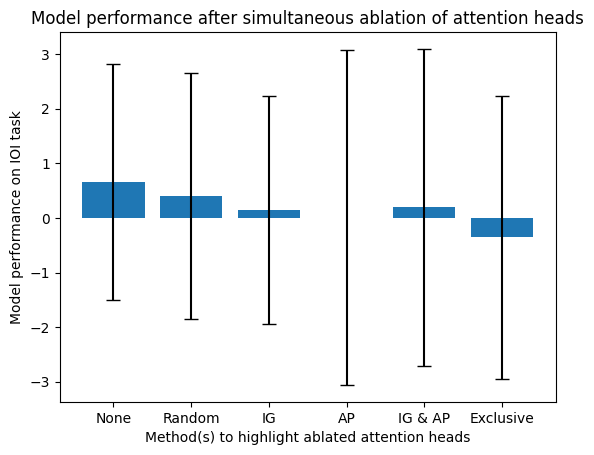

In [24]:
outlier_attn_multi_ablated_performance = torch.load("results/disagreements/outlier_attn_multi_ablated_performance.pt")
ig_attn_multi_ablated_performance = torch.load("results/disagreements/ig_attn_multi_ablated_performance.pt")
ap_attn_multi_ablated_performance = torch.load("results/disagreements/ap_attn_multi_ablated_performance.pt")
shared_attn_multi_ablated_performance = torch.load("results/disagreements/shared_attn_multi_ablated_performance.pt")
random_attn_multi_ablated_performance = torch.load("results/disagreements/random_attn_multi_ablated_performance.pt")

plt.title("Model performance after simultaneous ablation of attention heads")
plt.xlabel("Method(s) to highlight ablated attention heads")
plt.ylabel("Model performance on IOI task")

xs = ["None", "Random", "IG", "AP", "IG & AP", "Exclusive" ]
ys = [baseline_performance, random_attn_multi_ablated_performance.item(), ig_attn_multi_ablated_performance.item(), ap_attn_multi_ablated_performance.item(), shared_attn_multi_ablated_performance.item(), outlier_attn_multi_ablated_performance.item()]
yerr = [baseline_performance_std, ig_attn_multi_ablated_std.item(), random_attn_multi_ablated_performance_std.item(), ap_attn_multi_ablated_std.item(), shared_attn_multi_ablated_std.item(), outlier_attn_multi_ablated_std.item()]

plt.bar(xs, ys, yerr=yerr, capsize=5)
plt.show()

### Neurons

In [19]:
# Control: ablate random components (10% of the total number of components)
all_mlp_indices = [(layer, idx) for layer in range(model.cfg.n_layers) for idx in range(model.cfg.d_mlp)]
num_outliers = int(0.1 * model.cfg.n_layers * model.cfg.d_mlp)
random_mlp_multi = random.sample(all_mlp_indices, num_outliers)
random_mlp_outliers_multi = [(i, layer, idx) for i in range(num_outliers) for layer, idx in random_mlp_multi]

random_mlp_multi_ablated_performance, random_mlp_multi_ablated_performance_std = test_multi_ablated_performance(
    model, random_mlp_outliers_multi, mean_corrupt_activations, Task.IOI, is_attn=False
)
print(f"Random MLP multi-ablated performance: {random_mlp_multi_ablated_performance:.4f} (baseline: {baseline_performance:.4f})")

torch.save(random_mlp_multi_ablated_performance, "results/disagreements/random_mlp_multi_ablated_performance.pt")

Test IOI performance with 100 samples of ablated components
Mean performance: 0.5231845378875732, Std performance: 1.9637398719787598
Random MLP multi-ablated performance: 0.5232 (baseline: 0.6608)


In [20]:
# Ablate method-exclusive components
outlier_mlp_multi_ablated_performance, outlier_mlp_multi_ablated_std = test_multi_ablated_performance(model, mlp_outliers_multi, mean_corrupt_activations, Task.IOI, is_attn=False)

torch.save(outlier_mlp_multi_ablated_performance, "results/disagreements/outlier_mlp_multi_ablated_performance.pt")

Test IOI performance with 100 samples of ablated components
Mean performance: 0.4733470678329468, Std performance: 2.191392183303833


In [21]:
# Ablate all IG-highlighted components
ig_mlp_highlighted, ig_mlp_indices = highlight_components(ig_mlp)
ig_mlp_multi_ablated_performance, ig_mlp_multi_ablated_std = test_multi_ablated_performance(model, ig_mlp_indices, mean_corrupt_activations, Task.IOI, is_attn=False)

torch.save(ig_mlp_multi_ablated_performance, "results/disagreements/ig_mlp_multi_ablated_performance.pt")

# Ablate all AP-highlighted components
ap_mlp_highlighted, ap_mlp_indices = highlight_components(ap_mlp)
ap_mlp_multi_ablated_performance, ap_mlp_multi_ablated_std = test_multi_ablated_performance(model, ap_mlp_indices, mean_corrupt_activations, Task.IOI, is_attn=False)

torch.save(ap_mlp_multi_ablated_performance, "results/disagreements/ap_mlp_multi_ablated_performance.pt")

# Ablate all IG and AP highlighted components
shared_mlp_indices = (ig_mlp_highlighted & ap_mlp_highlighted).nonzero()
shared_mlp_multi_ablated_performance, shared_mlp_multi_ablated_std = test_multi_ablated_performance(model, shared_mlp_indices, mean_corrupt_activations, Task.IOI, is_attn=False)

torch.save(shared_mlp_multi_ablated_performance, "results/disagreements/shared_mlp_multi_ablated_performance.pt")

Test IOI performance with 100 samples of ablated components
Mean performance: 0.48984214663505554, Std performance: 2.498960018157959
Test IOI performance with 100 samples of ablated components
Mean performance: 0.507127046585083, Std performance: 2.324375867843628
Test IOI performance with 100 samples of ablated components
Mean performance: 0.4526919424533844, Std performance: 2.5435445308685303


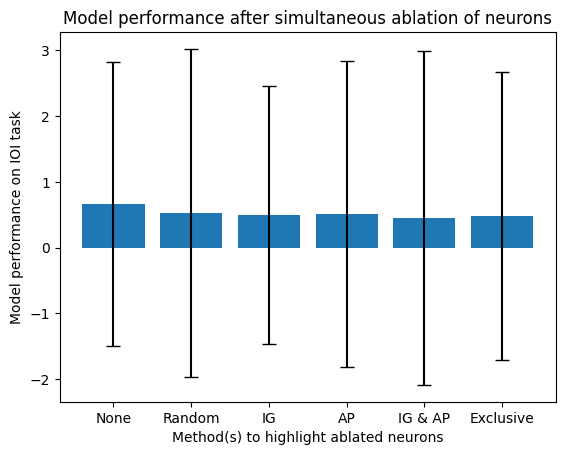

In [23]:
random_mlp_multi_ablated_performance = torch.load("results/disagreements/random_mlp_multi_ablated_performance.pt")
outlier_mlp_multi_ablated_performance = torch.load("results/disagreements/outlier_mlp_multi_ablated_performance.pt")
ig_mlp_multi_ablated_performance = torch.load("results/disagreements/ig_mlp_multi_ablated_performance.pt")
ap_mlp_multi_ablated_performance = torch.load("results/disagreements/ap_mlp_multi_ablated_performance.pt")
shared_mlp_multi_ablated_performance = torch.load("results/disagreements/shared_mlp_multi_ablated_performance.pt")

plt.title("Model performance after simultaneous ablation of neurons")
plt.xlabel("Method(s) to highlight ablated neurons")
plt.ylabel("Model performance on IOI task")

xs = ["None", "Random", "IG", "AP", "IG & AP", "Exclusive" ]
ys = [baseline_performance, random_mlp_multi_ablated_performance.item(), ig_mlp_multi_ablated_performance.item(), ap_mlp_multi_ablated_performance.item(), shared_mlp_multi_ablated_performance.item(), outlier_mlp_multi_ablated_performance.item()]
yerr = [baseline_performance_std, ig_mlp_multi_ablated_std.item(), random_mlp_multi_ablated_performance_std.item(), ap_mlp_multi_ablated_std.item(), shared_mlp_multi_ablated_std.item(), outlier_mlp_multi_ablated_std.item()]

plt.bar(xs, ys, yerr=yerr, capsize=5)
plt.show()